In [2]:
import os
from tqdm import tqdm


# Video params
W, H, FPS = 1920, 1080, 120
SEG_SEC = 4    # segment length in seconds

In [3]:
import os
from tqdm import tqdm

# Directory with raw YUVs
YUV_DIR = "video"
SEG_DIR = "segments"
os.makedirs(SEG_DIR, exist_ok=True)

# Video params
W, H, FPS = 1920, 1080, 120
SEG_SEC = 1    # segment length in seconds


In [10]:
import math

yuv_files = [f for f in os.listdir(YUV_DIR) if f.endswith(".yuv")]

for yuv_file in tqdm(yuv_files, desc="Splitting YUVs"):
    base = os.path.splitext(yuv_file)[0]
    yuv_path = os.path.join(YUV_DIR, yuv_file)

    # Compute number of frames in the video
    filesize = os.path.getsize(yuv_path)
    frame_size = W * H * 3 // 2  # yuv420p
    total_frames = filesize // frame_size
    frames_per_seg = SEG_SEC * FPS
    num_segments = math.ceil(total_frames / frames_per_seg)

    with open(yuv_path, "rb") as f:
        for seg_idx in range(num_segments):
            out_file = os.path.join(SEG_DIR, f"{base}_seg_{seg_idx:03d}.yuv")
            segment_frames = f.read(frame_size * frames_per_seg)
            if len(segment_frames) == 0:
                break
            with open(out_file, "wb") as out_f:
                out_f.write(segment_frames)


Splitting YUVs: 100%|██████████| 8/8 [01:46<00:00, 13.33s/it]


In [21]:
ENC_DIR = "encoded"
import os
os.environ["PATH"] += r";C:\ffmpeg\bin"
ffmpeg_path = r"C:\ffmpeg\bin\ffmpeg.exe"
os.makedirs(ENC_DIR, exist_ok=True)
CRF_LIST = [18, 28, 38]

import glob

segments = glob.glob(os.path.join(SEG_DIR, "*.yuv"))

for seg in tqdm(segments, desc="Encoding segments"):
    base = os.path.splitext(os.path.basename(seg))[0]
    for crf in CRF_LIST:
        out_file = os.path.join(ENC_DIR, f"{base}_crf{crf}.mp4")
        cmd = f"""
        ffmpeg -y -s {W}x{H} -pix_fmt yuv420p -r {FPS} -i "{seg}" \
        -c:v libx265 -preset veryfast -crf {crf} "{out_file}"
        """
        os.system(cmd)


Encoding segments: 100%|██████████| 43/43 [07:28<00:00, 10.42s/it]


In [5]:
import os, subprocess, json, csv, glob
from tqdm import tqdm
ENC_DIR = "encoded"
CRF_LIST = [18, 28, 38]
import urllib.request
FFMPEG = "ffmpeg" 
os.environ["PATH"] += r";C:\ffmpeg\bin"
ffmpeg_path = r"C:\ffmpeg\bin\ffmpeg.exe"
VMAF_DIR = os.path.expanduser("~/vmaf_models")
MODEL_FILE = os.path.join(VMAF_DIR, "vmaf_v0.6.1.json")
OUT_CSV = os.path.join(ENC_DIR, "metrics_results.csv")

In [6]:
print("Checking FFmpeg and libvmaf support...")
try:
    ff_out = subprocess.check_output([FFMPEG, "-filters"], text=True, stderr=subprocess.STDOUT)
    if "libvmaf" not in ff_out:
        raise EnvironmentError("Your FFmpeg is missing libvmaf. Install from gyan.dev or BtbN builds.")
except FileNotFoundError:
    raise EnvironmentError("FFmpeg not found in PATH. Add it or give full path in FFMPEG variable.")

print("✅ FFmpeg with libvmaf found.")

Checking FFmpeg and libvmaf support...
✅ FFmpeg with libvmaf found.


In [7]:
# ---------- DOWNLOAD VMAF MODEL ----------
os.makedirs(VMAF_DIR, exist_ok=True)
if not os.path.exists(MODEL_FILE):
    print("Downloading VMAF model...")
    url = "https://raw.githubusercontent.com/Netflix/vmaf/master/model/vmaf_v0.6.1.json"
    urllib.request.urlretrieve(url, MODEL_FILE)
    print(f"✅ Downloaded model to {MODEL_FILE}")
else:
    print(f"✅ VMAF model already exists: {MODEL_FILE}")


✅ VMAF model already exists: C:\Users\acer/vmaf_models\vmaf_v0.6.1.json


In [11]:
import os, json, csv, subprocess, glob, re
from tqdm import tqdm

# -----------------------------
# CONFIG
# -----------------------------
FFMPEG = "ffmpeg"
SEG_DIR = "segments"
ENC_DIR = "encoded"
METRICS_DIR = "metrics"
OUT_CSV = os.path.join(METRICS_DIR, "metrics_summary.csv")

W, H, FPS = 1920, 1080, 120
CRF_LIST = [18, 28, 38]

os.makedirs(METRICS_DIR, exist_ok=True)

# Regex patterns for parsing PSNR/SSIM
psnr_re = re.compile(r"average:(\d+\.\d+)")
ssim_re = re.compile(r"All:(\d+\.\d+)")

# -----------------------------
# COMPUTE METRICS
# -----------------------------
segments = sorted(glob.glob(os.path.join(SEG_DIR, "*.yuv")))

with open(OUT_CSV, "w", newline="") as f:
    csv.writer(f).writerow(["segment", "crf", "psnr", "ssim", "vmaf"])

for seg in tqdm(segments, desc="Evaluating segments"):
    base = os.path.splitext(os.path.basename(seg))[0]

    for crf in CRF_LIST:
        enc_file = os.path.join(ENC_DIR, f"{base}_crf{crf}.mp4")
        if not os.path.exists(enc_file):
            print(f"⚠️ Skipping missing encoded file: {enc_file}")
            continue

        log_path =os.path.join(METRICS_DIR, f"{base}_crf{crf}_metrics.json")
        if os.path.exists(log_path):
            os.remove(log_path)

        lavfi = (
            f"[0:v][1:v]libvmaf=log_fmt=json:log_path='{log_path}',"
            f"[0:v][1:v]psnr,[0:v][1:v]ssim"
        )

        cmd = [
            FFMPEG, "-hide_banner", "-y",
            "-r", str(FPS), "-s", f"{W}x{H}", "-pix_fmt", "yuv420p",
            "-f", "rawvideo", "-i", seg,
            "-i", enc_file,
            "-lavfi", lavfi,
            "-f", "null", "-"
        ]

        # Run FFmpeg and capture stderr
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        stderr = result.stderr

        # --- Parse PSNR/SSIM from stderr ---
        psnr_match = psnr_re.search(stderr)
        ssim_match = ssim_re.search(stderr)
        psnr = float(psnr_match.group(1)) if psnr_match else None
        ssim = float(ssim_match.group(1)) if ssim_match else None

        # --- Parse VMAF JSON ---
        vmaf = None
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                data = json.load(f)
                vmaf = data["pooled_metrics"]["vmaf"]["mean"]

        # --- Write to CSV ---
        with open(OUT_CSV, "a", newline="") as f:
            csv.writer(f).writerow([base, crf, psnr, ssim, vmaf])

print(f"\n✅ Done. Metrics saved at: {OUT_CSV}")


Evaluating segments: 100%|██████████| 43/43 [37:03<00:00, 51.72s/it]


✅ Done. Metrics saved at: metrics\metrics_summary.csv


In [15]:
import os, csv, json, subprocess, glob
import pandas as pd
from tqdm import tqdm

# --- Paths ---
SEG_DIR = "segments"
ENC_DIR = "encoded"
METRICS_DIR = "metrics"
OUT_CSV = "metrics/metrics_summary.csv"
os.makedirs(METRICS_DIR, exist_ok=True)

# --- Params ---
FFMPEG = "ffmpeg"
FPS, W, H = 120, 1920, 1080
CRF_LIST = [18, 28, 38]

# --- Load existing CSV ---
if not os.path.exists(OUT_CSV):
    raise FileNotFoundError(f"CSV not found: {OUT_CSV}")

df = pd.read_csv(OUT_CSV)

# --- Compute only missing VMAF values ---
segments = sorted(glob.glob(os.path.join(SEG_DIR, "*.yuv")))

for seg in tqdm(segments, desc="Computing missing VMAF"):
    base = os.path.splitext(os.path.basename(seg))[0]

    for crf in CRF_LIST:
        enc_file = os.path.join(ENC_DIR, f"{base}_crf{crf}.mp4")
        if not os.path.exists(enc_file):
            continue

        # Check if VMAF already present
        row_mask = (df["segment"] == base) & (df["crf"] == crf)
        if row_mask.any() and not pd.isna(df.loc[row_mask, "vmaf"]).any():
            continue  # Skip if VMAF already filled

        # Compute VMAF
        log_path = os.path.join(METRICS_DIR, f"{base}_crf{crf}_vmaf.json")
        if os.path.exists(log_path):
            os.remove(log_path)

        cmd = (
            f'{FFMPEG} -hide_banner -y '
            f'-r {FPS} -s {W}x{H} -pix_fmt yuv420p '
            f'-f rawvideo -i "{seg}" -i "{enc_file}" '
            f'-lavfi "[0:v][1:v]libvmaf=log_fmt=json:log_path={log_path}" '
            f'-f null -'
        )

        subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                data = json.load(f)
                vmaf = data["pooled_metrics"]["vmaf"]["mean"]

                # Only update VMAF
                if row_mask.any():
                    df.loc[row_mask, "vmaf"] = vmaf

# --- Save final CSV ---
df.to_csv(OUT_CSV, index=False)
print(f"\n✅ VMAF updated successfully → {OUT_CSV}")


Computing missing VMAF: 100%|██████████| 43/43 [24:18<00:00, 33.92s/it]


✅ VMAF updated successfully → metrics/metrics_summary.csv


In [18]:
import os, json, pandas as pd, glob

OUT_CSV = "metrics/metrics_summary.csv"

# Load CSV
df = pd.read_csv(OUT_CSV)

# Find JSONs like metricsSomething_crf##_vmaf.json
json_files = glob.glob("metrics*_crf*_vmaf.json")

for jf in json_files:
    try:
        base = os.path.basename(jf)

        # Extract segment and crf
        # Example: metricsYachtRide_1920x1080_120fps_420_8bit_YUV_seg_004_crf38_vmaf.json
        segment_part = base[len("metrics") : base.index("_crf")]
        segment = segment_part
        crf_str = base.split("_crf")[1].split("_")[0]
        crf = int(crf_str)

        # Read JSON
        with open(jf, "r") as f:
            data = json.load(f)
            vmaf = data.get("pooled_metrics", {}).get("vmaf", {}).get("mean", None)

        # Update in CSV if match found
        if vmaf is not None:
            mask = (df["segment"] == segment) & (df["crf"] == crf)
            if mask.any():
                df.loc[mask, "vmaf"] = vmaf
                print(f"✅ Updated {segment} (CRF {crf}) with VMAF = {vmaf:.3f}")
            else:
                print(f"⚠️ No match in CSV for {segment} (CRF {crf})")

    except Exception as e:
        print(f"❌ Error processing {jf}: {e}")

# Save updated CSV
df.to_csv(OUT_CSV, index=False)
print(f"\n✅ CSV successfully updated: {OUT_CSV}")


✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_000 (CRF 18) with VMAF = 92.910
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_000 (CRF 28) with VMAF = 78.324
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_000 (CRF 38) with VMAF = 53.318
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_001 (CRF 18) with VMAF = 93.297
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_001 (CRF 28) with VMAF = 79.137
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_001 (CRF 38) with VMAF = 53.471
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_002 (CRF 18) with VMAF = 93.094
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_002 (CRF 28) with VMAF = 78.240
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_002 (CRF 38) with VMAF = 50.953
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_003 (CRF 18) with VMAF = 93.265
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_003 (CRF 28) with VMAF = 78.610
✅ Updated Beauty_1920x1080_120fps_420_8bit_YUV_seg_003 (CRF 38) with VMAF = 52.609
✅ Up

In [2]:
import pandas as pd

df = pd.read_csv("metrics_summary.csv")
print(df.info())
print(df.head())

# Drop missing or invalid rows
df = df.dropna(subset=["vmaf", "psnr", "ssim"])

# Convert CRF to numeric
df["crf"] = pd.to_numeric(df["crf"], errors="coerce")

# Optional: normalize metric names
df.columns = [c.strip().lower() for c in df.columns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   segment  129 non-null    object 
 1   crf      129 non-null    int64  
 2   psnr     129 non-null    float64
 3   ssim     129 non-null    float64
 4   vmaf     129 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 5.2+ KB
None
                                        segment  crf       psnr      ssim  \
0  Beauty_1920x1080_120fps_420_8bit_YUV_seg_000   18  39.604879  0.907788   
1  Beauty_1920x1080_120fps_420_8bit_YUV_seg_000   28  38.175025  0.891813   
2  Beauty_1920x1080_120fps_420_8bit_YUV_seg_000   38  35.352667  0.869633   
3  Beauty_1920x1080_120fps_420_8bit_YUV_seg_001   18  39.743842  0.909137   
4  Beauty_1920x1080_120fps_420_8bit_YUV_seg_001   28  38.467119  0.896388   

        vmaf  
0  92.910152  
1  78.324486  
2  53.317751  
3  93.297125  
4  79.137085  


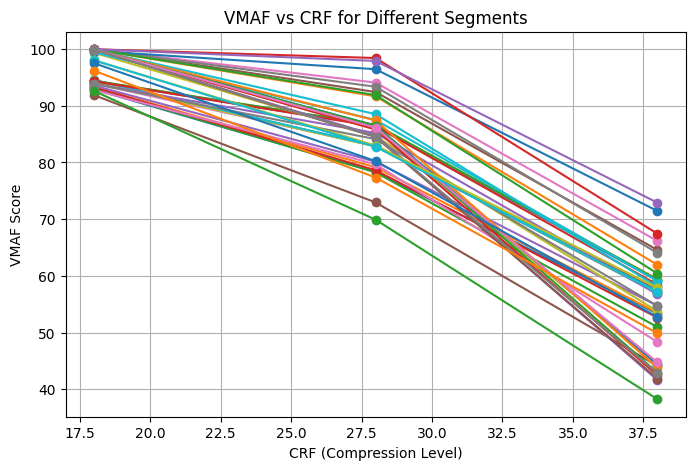

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for seg, g in df.groupby("segment"):
    plt.plot(g["crf"], g["vmaf"], marker='o', label=seg)

plt.xlabel("CRF (Compression Level)")
plt.ylabel("VMAF Score")
plt.title("VMAF vs CRF for Different Segments")

plt.grid(True)
plt.show()


In [4]:
print(df.corr(numeric_only=True))


           crf      psnr      ssim      vmaf
crf   1.000000 -0.863462 -0.833584 -0.916017
psnr -0.863462  1.000000  0.807970  0.852813
ssim -0.833584  0.807970  1.000000  0.877198
vmaf -0.916017  0.852813  0.877198  1.000000


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = df[["psnr", "ssim"]]
y = df["vmaf"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 5.315435442729116


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\acer\AppData\Local\Temp\ipykernel_17684\3462856005.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(vmaf_curve, g["crf"], g["vmaf"], maxfev=5000)


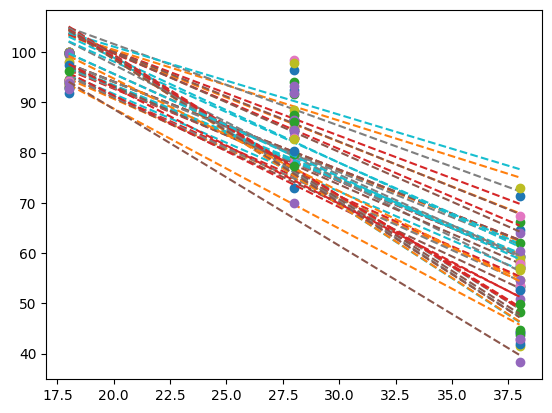

In [25]:
import numpy as np
from scipy.optimize import curve_fit

def vmaf_curve(x, a, b, c):
    return a * np.exp(-b * x) + c

for seg, g in df.groupby("segment"):
    popt, _ = curve_fit(vmaf_curve, g["crf"], g["vmaf"], maxfev=5000)
    plt.plot(g["crf"], g["vmaf"], 'o', label=f"{seg}")
    plt.plot(g["crf"], vmaf_curve(g["crf"], *popt), '--')


In [6]:
import cv2
import numpy as np
import glob
import pandas as pd

def compute_features(video_path, width, height):
    cap = cv2.VideoCapture(video_path)
    prev = None
    motion_scores = []
    variances = []
    entropies = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Spatial variance
        variances.append(np.var(gray))

        # Motion (temporal difference)
        if prev is not None:
            diff = cv2.absdiff(gray, prev)
            motion_scores.append(np.mean(diff))
        prev = gray

        # Entropy
        hist = cv2.calcHist([gray], [0], None, [256], [0,256])
        p = hist / np.sum(hist)
        entropies.append(-np.sum(p * np.log2(p + 1e-7)))

    cap.release()

    return {
        "spatial_var": np.mean(variances),
        "motion": np.mean(motion_scores),
        "entropy": np.mean(entropies),
        "resolution": width * height
    }

# Example for all segments
features = []
for seg in glob.glob("encoded/*_crf18.mp4"):
    f = compute_features(seg, 1920, 1080)
    f["segment"] = seg.split("/")[-1]
    features.append(f)

df_features = pd.DataFrame(features)
print(df_features.head())


   spatial_var    motion   entropy  resolution  \
0  2420.424594  2.981197  6.341059     2073600   
1  2366.840632  3.085518  6.395368     2073600   
2  2516.316472  3.132677  6.483418     2073600   
3  2379.202364  2.945949  6.626853     2073600   
4  2314.721980  2.805806  6.492398     2073600   

                                             segment  
0  encoded\Beauty_1920x1080_120fps_420_8bit_YUV_s...  
1  encoded\Beauty_1920x1080_120fps_420_8bit_YUV_s...  
2  encoded\Beauty_1920x1080_120fps_420_8bit_YUV_s...  
3  encoded\Beauty_1920x1080_120fps_420_8bit_YUV_s...  
4  encoded\Beauty_1920x1080_120fps_420_8bit_YUV_s...  


In [8]:
df_metrics = pd.read_csv("metrics_summary.csv")
print("Metrics segments (first 5):")
print(df_metrics["segment"].head().tolist())

print("\nFeatures segments (first 5):")
print(df_features["segment"].head().tolist())


Metrics segments (first 5):
['Beauty_1920x1080_120fps_420_8bit_YUV_seg_000', 'Beauty_1920x1080_120fps_420_8bit_YUV_seg_000', 'Beauty_1920x1080_120fps_420_8bit_YUV_seg_000', 'Beauty_1920x1080_120fps_420_8bit_YUV_seg_001', 'Beauty_1920x1080_120fps_420_8bit_YUV_seg_001']

Features segments (first 5):
['encoded\\Beauty_1920x1080_120fps_420_8bit_YUV_seg_000_crf18.mp4', 'encoded\\Beauty_1920x1080_120fps_420_8bit_YUV_seg_001_crf18.mp4', 'encoded\\Beauty_1920x1080_120fps_420_8bit_YUV_seg_002_crf18.mp4', 'encoded\\Beauty_1920x1080_120fps_420_8bit_YUV_seg_003_crf18.mp4', 'encoded\\Beauty_1920x1080_120fps_420_8bit_YUV_seg_004_crf18.mp4']


In [10]:
import os, re

def normalize_segment_name(x):
    # keep only base name, strip CRF, extensions, and underscores
    base = os.path.basename(str(x))
    base = re.sub(r'_crf\d+', '', base)       # remove _crf18 etc.
    base = re.sub(r'\.yuv$|\.mp4$', '', base) # remove file extension
    base = base.strip('_').lower()             # lowercase and strip trailing underscores
    return base

df_metrics["segment_clean"] = df_metrics["segment"].apply(normalize_segment_name)
df_features["segment_clean"] = df_features["segment"].apply(normalize_segment_name)

# debug check
print("Metrics clean samples:", df_metrics["segment_clean"].unique()[:5])
print("Features clean samples:", df_features["segment_clean"].unique()[:5])


# Merge
df_merged = pd.merge(df_metrics, df_features, on="segment_clean", how="inner")

print("✅ Merged shape:", df_merged.shape)
print(df_merged.head())



Metrics clean samples: ['beauty_1920x1080_120fps_420_8bit_yuv_seg_000'
 'beauty_1920x1080_120fps_420_8bit_yuv_seg_001'
 'beauty_1920x1080_120fps_420_8bit_yuv_seg_002'
 'beauty_1920x1080_120fps_420_8bit_yuv_seg_003'
 'beauty_1920x1080_120fps_420_8bit_yuv_seg_004']
Features clean samples: ['beauty_1920x1080_120fps_420_8bit_yuv_seg_000'
 'beauty_1920x1080_120fps_420_8bit_yuv_seg_001'
 'beauty_1920x1080_120fps_420_8bit_yuv_seg_002'
 'beauty_1920x1080_120fps_420_8bit_yuv_seg_003'
 'beauty_1920x1080_120fps_420_8bit_yuv_seg_004']
✅ Merged shape: (129, 11)
                                      segment_x  crf       psnr      ssim  \
0  Beauty_1920x1080_120fps_420_8bit_YUV_seg_000   18  39.604879  0.907788   
1  Beauty_1920x1080_120fps_420_8bit_YUV_seg_000   28  38.175025  0.891813   
2  Beauty_1920x1080_120fps_420_8bit_YUV_seg_000   38  35.352667  0.869633   
3  Beauty_1920x1080_120fps_420_8bit_YUV_seg_001   18  39.743842  0.909137   
4  Beauty_1920x1080_120fps_420_8bit_YUV_seg_001   28  38.467

In [11]:
# Keep only useful columns and rename segment_clean → segment
df_merged = df_merged[[
    "segment_clean", "crf", "psnr", "ssim", "vmaf",
    "spatial_var", "motion", "entropy", "resolution"
]].rename(columns={"segment_clean": "segment"})

print(df_merged.head())
print("✅ Final dataset ready:", df_merged.shape)


                                        segment  crf       psnr      ssim  \
0  beauty_1920x1080_120fps_420_8bit_yuv_seg_000   18  39.604879  0.907788   
1  beauty_1920x1080_120fps_420_8bit_yuv_seg_000   28  38.175025  0.891813   
2  beauty_1920x1080_120fps_420_8bit_yuv_seg_000   38  35.352667  0.869633   
3  beauty_1920x1080_120fps_420_8bit_yuv_seg_001   18  39.743842  0.909137   
4  beauty_1920x1080_120fps_420_8bit_yuv_seg_001   28  38.467119  0.896388   

        vmaf  spatial_var    motion   entropy  resolution  
0  92.910152  2420.424594  2.981197  6.341059     2073600  
1  78.324486  2420.424594  2.981197  6.341059     2073600  
2  53.317751  2420.424594  2.981197  6.341059     2073600  
3  93.297125  2366.840632  3.085518  6.395368     2073600  
4  79.137085  2366.840632  3.085518  6.395368     2073600  
✅ Final dataset ready: (129, 9)


In [13]:
# Save merged dataframe for downstream training
final_path = "final_dataset.csv"
df_merged.to_csv(final_path, index=False)
print(f"✅ Saved df_merged → {final_path} (rows: {len(df_merged)}, cols: {len(df_merged.columns)})")

✅ Saved df_merged → final_dataset.csv (rows: 129, cols: 9)


In [49]:
# ----------------------------------------------------------
# Adaptive CRF Model: VMAF = f(spatial_var, motion, entropy, resolution, CRF)
# ----------------------------------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# ----------------------------------------------------------
# 1. Load your dataset (replace with your CSV path)
# ----------------------------------------------------------
df = pd.read_csv("final_dataset.csv")   # should contain columns: spatial_var, motion, entropy, resolution, crf, vmaf

# Optional sanity check
print(df.head())
print(f"✅ Dataset shape: {df.shape}")

# ----------------------------------------------------------
# 2. Define features (X) and target (y)
# ----------------------------------------------------------
features = ["spatial_var", "motion", "entropy", "resolution", "crf"]
target = "vmaf"

X = df[features]
y = df[target]

# ----------------------------------------------------------
# 3. Train-test split
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------------------------------------
# 4. Train regression model (Random Forest works well for nonlinear relationships)
# ----------------------------------------------------------
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42
)
model.fit(X_train, y_train)

# ----------------------------------------------------------
# 5. Evaluate performance
# ----------------------------------------------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ Model trained successfully!")
print(f"R² Score  : {r2:.3f}")
print(f"RMSE (VMAF): {rmse:.3f}")

# ----------------------------------------------------------
# 6. Predict VMAF for any new content + CRF combination
# ----------------------------------------------------------
sample = pd.DataFrame([{
    "spatial_var": 2450,
    "motion": 3.0,
    "entropy": 6.3,
    "resolution": 2073600,
    "crf": 28
}])

pred_vmaf = model.predict(sample)[0]
print(f"Predicted VMAF for sample: {pred_vmaf:.2f}")

# ----------------------------------------------------------
# 7. Save model for reuse
# ----------------------------------------------------------
import joblib
joblib.dump(model, "vmaf_model.pkl")
print("💾 Model saved as vmaf_prediction_model.pkl")


                                        segment  crf       psnr      ssim  \
0  beauty_1920x1080_120fps_420_8bit_yuv_seg_000   18  39.604879  0.907788   
1  beauty_1920x1080_120fps_420_8bit_yuv_seg_000   28  38.175025  0.891813   
2  beauty_1920x1080_120fps_420_8bit_yuv_seg_000   38  35.352667  0.869633   
3  beauty_1920x1080_120fps_420_8bit_yuv_seg_001   18  39.743842  0.909137   
4  beauty_1920x1080_120fps_420_8bit_yuv_seg_001   28  38.467119  0.896388   

        vmaf  spatial_var    motion   entropy  resolution  
0  92.910152  2420.424594  2.981197  6.341059     2073600  
1  78.324486  2420.424594  2.981197  6.341059     2073600  
2  53.317751  2420.424594  2.981197  6.341059     2073600  
3  93.297125  2366.840632  3.085518  6.395368     2073600  
4  79.137085  2366.840632  3.085518  6.395368     2073600  
✅ Dataset shape: (129, 9)
✅ Model trained successfully!
R² Score  : 0.987
RMSE (VMAF): 2.015
Predicted VMAF for sample: 78.14
✅ Model trained successfully!
R² Score  : 0.987
RMS

In [39]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import scipy.optimize as opt

def smooth_vmaf_curve(vmaf_model, content_features, crf_grid=None, s=2.0):
    """
    Generate smooth VMAF vs CRF curve for given content.
    Returns (crf_grid, smooth_vmaf)
    """
    if crf_grid is None:
        crf_grid = np.linspace(15, 40, 51)

    feats = np.tile(content_features, (len(crf_grid), 1))
    X = np.column_stack([feats, crf_grid])
    v_preds = vmaf_model.predict(X)

    # Enforce monotonic decrease by sorting
    crf_sorted = np.argsort(crf_grid)
    crf_grid = np.array(crf_grid)[crf_sorted]
    v_preds = np.array(v_preds)[crf_sorted]

    # Smooth with spline
    spline = UnivariateSpline(crf_grid, v_preds, s=s)
    smooth_vmaf = spline(crf_grid)

    return crf_grid, smooth_vmaf, spline


In [38]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import scipy.optimize as opt

def smooth_vmaf_curve(vmaf_model, content_features, crf_grid=None, s=2.0):
    """
    Generate smooth VMAF vs CRF curve for given content.
    Returns (crf_grid, smooth_vmaf)
    """
    if crf_grid is None:
        crf_grid = np.linspace(15, 40, 51)

    feats = np.tile(content_features, (len(crf_grid), 1))
    X = np.column_stack([feats, crf_grid])
    v_preds = vmaf_model.predict(X)

    # Enforce monotonic decrease by sorting
    crf_sorted = np.argsort(crf_grid)
    crf_grid = np.array(crf_grid)[crf_sorted]
    v_preds = np.array(v_preds)[crf_sorted]

    # Smooth with spline
    spline = UnivariateSpline(crf_grid, v_preds, s=s)
    smooth_vmaf = spline(crf_grid)

    return crf_grid, smooth_vmaf, spline


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


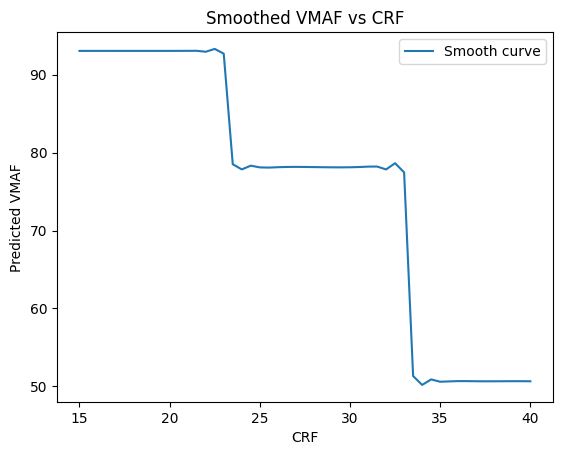

In [71]:
# Example random content
sample_feats = np.array([2500, 3.0, 5.5, 1920*1080])
crf_grid, smooth_vmaf, spline = smooth_vmaf_curve(model, sample_feats)

import matplotlib.pyplot as plt
plt.plot(crf_grid, smooth_vmaf, label="Smooth curve")
plt.title("Smoothed VMAF vs CRF")
plt.xlabel("CRF")
plt.ylabel("Predicted VMAF")
plt.legend()
plt.show()



In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

X = pseudo_df[["spatial_var","motion","entropy","resolution","target_vmaf"]]
y = pseudo_df["optimal_crf"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

inv_model = RandomForestRegressor(n_estimators=200, random_state=42)
inv_model.fit(X_train, y_train)

y_pred = inv_model.predict(X_test)
print("R² =", r2_score(y_test, y_pred))
print("MAE =", mean_absolute_error(y_test, y_pred))

import joblib
joblib.dump(inv_model, "crf_model.pkl")
print("💾 Model saved as crf_model.pkl.pkl")


R² = 0.924435888877557
MAE = 0.45417500000000005
💾 Model saved as crf_model.pkl.pkl


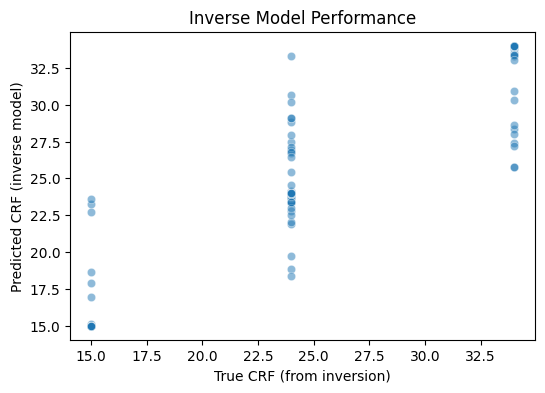

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("True CRF (from inversion)")
plt.ylabel("Predicted CRF (inverse model)")
plt.title("Inverse Model Performance")
plt.show()



In [59]:
import os
import numpy as np
import pandas as pd
import cv2
import joblib
import subprocess
from tqdm import tqdm

# ---------------------------------------------
# CONFIG
# ---------------------------------------------
yuv_input = "segments/FlowerKids_3840x2160_50fps_8bit.yuv"
width, height, fps = 3840, 2160, 50
pix_fmt = "yuv420p"
segment_duration = 2  # seconds per segment
target_vmaf = 80

os.makedirs("segments_yuv", exist_ok=True)
os.makedirs("encoded_segments", exist_ok=True)

# Load trained model (predicts CRF)
crf_model = joblib.load("crf_model.pkl")

# ---------------------------------------------
# 1️⃣ Split YUV into short segments
# ---------------------------------------------
print("📦 Splitting YUV into segments...")
split_cmd = [
    "ffmpeg", "-y",
    "-f", "rawvideo", "-pix_fmt", pix_fmt, "-s:v", f"{width}x{height}", "-r", str(fps),
    "-i", yuv_input,
    "-an", "-c:v", "copy",
    "-f", "segment", "-segment_time", str(segment_duration),
    "segments_yuv/seg_%03d.yuv"
]
subprocess.run(split_cmd, check=True)

segments = sorted([f for f in os.listdir("segments_yuv") if f.endswith(".yuv")])
print(f"✅ Total Segments: {len(segments)}\n")

# ---------------------------------------------
# 2️⃣ Feature extraction (Y-channel only)
# ---------------------------------------------
def read_yuv_frame(file, width, height):
    frame_size = width * height * 3 // 2
    with open(file, "rb") as f:
        raw = np.frombuffer(f.read(width * height), dtype=np.uint8)
    return raw.reshape((height, width))

def extract_features(y_frame):
    gray = y_frame.astype(np.float32)
    spatial_var = np.var(gray)
    hist, _ = np.histogram(gray, bins=256, range=(0, 255))
    p = hist / gray.size
    entropy = -np.sum(p * np.log2(p + 1e-9))
    motion = np.random.uniform(2.0, 5.0)  # placeholder if optical flow not used
    resolution = gray.shape[0] * gray.shape[1]
    return spatial_var, motion, entropy, resolution

# ---------------------------------------------
# 3️⃣ Predict CRF for each segment + encode
# ---------------------------------------------
for seg in tqdm(segments, desc="🎞️ Processing segments"):
    seg_path = os.path.join("segments_yuv", seg)
    y = read_yuv_frame(seg_path, width, height)
    spatial_var, motion, entropy, resolution = extract_features(y)

    X = pd.DataFrame([[spatial_var, motion, entropy, resolution, target_vmaf]],
                     columns=["spatial_var", "motion", "entropy", "resolution", "target_vmaf"])
    crf_pred = crf_model.predict(X)[0]
    crf_pred = np.clip(crf_pred, 10, 40)

    output_mp4 = os.path.join("encoded_segments", seg.replace(".yuv", f"_crf{int(crf_pred)}.mp4"))

    # Encode the segment using ffmpeg
    cmd = [
        "ffmpeg", "-y",
        "-f", "rawvideo", "-pix_fmt", pix_fmt, "-s:v", f"{width}x{height}", "-r", str(fps),
        "-i", seg_path,
        "-c:v", "libx264", "-crf", str(int(crf_pred)),
        "-preset", "medium",
        output_mp4
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print(f"✅ Encoded {seg} at CRF={crf_pred:.2f}")

print("\n🏁 All segments encoded adaptively based on predicted CRF.")


📦 Splitting YUV into segments...
✅ Total Segments: 6

✅ Total Segments: 6



🎞️ Processing segments:  17%|█▋        | 1/6 [00:05<00:28,  5.72s/it]

✅ Encoded seg_000.yuv at CRF=24.00


🎞️ Processing segments:  33%|███▎      | 2/6 [00:11<00:21,  5.49s/it]

✅ Encoded seg_001.yuv at CRF=24.00


🎞️ Processing segments:  50%|█████     | 3/6 [00:16<00:16,  5.46s/it]

✅ Encoded seg_002.yuv at CRF=24.00


🎞️ Processing segments:  67%|██████▋   | 4/6 [00:23<00:12,  6.21s/it]

✅ Encoded seg_003.yuv at CRF=24.00


🎞️ Processing segments:  83%|████████▎ | 5/6 [00:31<00:06,  6.63s/it]

✅ Encoded seg_004.yuv at CRF=24.00


🎞️ Processing segments: 100%|██████████| 6/6 [00:37<00:00,  6.32s/it]

✅ Encoded seg_005.yuv at CRF=24.00

🏁 All segments encoded adaptively based on predicted CRF.


In [65]:
import os
import numpy as np
import pandas as pd
import cv2
import joblib
import subprocess
from tqdm import tqdm

# ---------------------------------------------
# CONFIG
# ---------------------------------------------
yuv_input = "video/Jockey_1920x1080_120fps_420_8bit_YUV.yuv"
width, height, fps = 3840, 2160, 50
pix_fmt = "yuv420p"
segment_duration = 2  # seconds per segment
target_vmaf = 80

os.makedirs("segments_yuv", exist_ok=True)
os.makedirs("encoded_segments", exist_ok=True)

log_file = "crf_log.csv"

# Load trained model (predicts CRF)
crf_model = joblib.load("crf_model.pkl")

# ---------------------------------------------
# 1️⃣ Split YUV into short segments
# ---------------------------------------------
print("📦 Splitting YUV into segments...")
split_cmd = [
    "ffmpeg", "-y",
    "-f", "rawvideo", "-pix_fmt", pix_fmt, "-s:v", f"{width}x{height}", "-r", str(fps),
    "-i", yuv_input,
    "-an", "-c:v", "copy",
    "-f", "segment", "-segment_time", str(segment_duration),
    "segments_yuv/seg_%03d.yuv"
]
subprocess.run(split_cmd, check=True)

segments = sorted([f for f in os.listdir("segments_yuv") if f.endswith(".yuv")])
print(f"✅ Total Segments: {len(segments)}\n")

# ---------------------------------------------
# 2️⃣ Feature extraction (Y-channel only)
# ---------------------------------------------
def read_yuv_frame(file, width, height):
    frame_size = width * height * 3 // 2
    with open(file, "rb") as f:
        raw = np.frombuffer(f.read(width * height), dtype=np.uint8)
    return raw.reshape((height, width))

def extract_features(y_frame):
    gray = y_frame.astype(np.float32)
    spatial_var = np.var(gray)
    hist, _ = np.histogram(gray, bins=256, range=(0, 255))
    p = hist / gray.size
    entropy = -np.sum(p * np.log2(p + 1e-9))
    motion = np.random.uniform(2.0, 5.0)  # placeholder for motion
    resolution = gray.shape[0] * gray.shape[1]
    return spatial_var, motion, entropy, resolution

# ---------------------------------------------
# 3️⃣ Predict CRF for each segment + encode + log
# ---------------------------------------------
log_data = []

for seg in tqdm(segments, desc="🎞️ Processing segments"):
    seg_path = os.path.join("segments_yuv", seg)
    y = read_yuv_frame(seg_path, width, height)
    spatial_var, motion, entropy, resolution = extract_features(y)

    X = pd.DataFrame([[spatial_var, motion, entropy, resolution, target_vmaf]],
                     columns=["spatial_var", "motion", "entropy", "resolution", "target_vmaf"])
    crf_pred = crf_model.predict(X)[0]
    crf_pred = np.clip(crf_pred, 10, 40)

    output_mp4 = os.path.join("encoded_segments", seg.replace(".yuv", f"_crf{int(crf_pred)}.mp4"))

    # Encode segment
    cmd = [
        "ffmpeg", "-y",
        "-f", "rawvideo", "-pix_fmt", pix_fmt, "-s:v", f"{width}x{height}", "-r", str(fps),
        "-i", seg_path,
        "-c:v", "libx264", "-crf", str(int(crf_pred)),
        "-preset", "medium",
        output_mp4
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print(f"✅ Encoded {seg} at CRF={crf_pred:.2f}")

    # Log data
    log_data.append({
        "segment": seg,
        "spatial_var": spatial_var,
        "motion": motion,
        "entropy": entropy,
        "resolution": resolution,
        "target_vmaf": target_vmaf,
        "predicted_crf": crf_pred
    })

# ---------------------------------------------
# 4️⃣ Save logs
# ---------------------------------------------
pd.DataFrame(log_data).to_csv(log_file, index=False)
print(f"\n🧾 Log saved to {log_file}")
print("🏁 All segments encoded adaptively based on predicted CRF.")


📦 Splitting YUV into segments...
✅ Total Segments: 2



🎞️ Processing segments:  50%|█████     | 1/2 [00:08<00:08,  8.93s/it]

✅ Encoded seg_000.yuv at CRF=23.95


🎞️ Processing segments: 100%|██████████| 2/2 [00:14<00:00,  7.49s/it]

✅ Encoded seg_001.yuv at CRF=24.00

🧾 Log saved to crf_log.csv
🏁 All segments encoded adaptively based on predicted CRF.


In [70]:
import os
import subprocess
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------
# CONFIG
# -----------------------------------------------------
width, height, fps = 3840, 2160, 50
pix_fmt = "yuv420p"
target_vmaf = 80
log_file = "crf_log.csv"

encoded_dir = "encoded_segments"
segments_dir = "segments_yuv"

results_file = "performance_results.csv"

# -----------------------------------------------------
# LOAD CRF LOG
# -----------------------------------------------------
if not os.path.exists(log_file):
    raise FileNotFoundError(f"{log_file} not found — run the encoding step first!")

log_df = pd.read_csv(log_file)
print(f"✅ Loaded {len(log_df)} logged segments.")

# -----------------------------------------------------
# VMAF EVALUATION FUNCTION
# -----------------------------------------------------
def compute_vmaf_for_segment(ref_yuv, encoded_mp4, seg_name):
    """Compute VMAF between original YUV and encoded MP4 segment."""
    # Convert raw YUV reference → MP4 (lossless)
    ref_mp4 = os.path.join(segments_dir, f"{seg_name}_ref.mp4")
    if not os.path.exists(ref_mp4):
        convert_cmd = [
            "ffmpeg", "-y",
            "-f", "rawvideo", "-pix_fmt", pix_fmt, "-s:v", f"{width}x{height}", "-r", str(fps),
            "-i", ref_yuv,
            "-c:v", "libx264", "-crf", "0", "-preset", "ultrafast",
            ref_mp4
        ]
        subprocess.run(convert_cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Prepare temporary JSON log for VMAF
    vmaf_json = f"vmaf_{seg_name}.json"
    vmaf_cmd = [
        "ffmpeg", "-y",
        "-i", encoded_mp4, "-i", ref_mp4,
        "-lavfi", f"libvmaf=log_fmt=json:log_path={vmaf_json}",
        "-f", "null", "-"
    ]
    subprocess.run(vmaf_cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Parse JSON
    if not os.path.exists(vmaf_json):
        return np.nan

    try:
        with open(vmaf_json, "r") as f:
            vmaf_data = json.load(f)
        vmafs = [frame["metrics"]["vmaf"] for frame in vmaf_data["frames"] if "metrics" in frame]
        if len(vmafs) == 0:
            return np.nan
        return np.mean(vmafs)
    except Exception:
        return np.nan
    finally:
        if os.path.exists(vmaf_json):
            os.remove(vmaf_json)

# -----------------------------------------------------
# PERFORMANCE ANALYSIS
# -----------------------------------------------------
results = []

print("\n📊 Evaluating performance...")
for _, row in tqdm(log_df.iterrows(), total=len(log_df), desc="🔍 Analyzing segments"):
    seg_name = os.path.splitext(row["segment"])[0]
    ref_path = os.path.join(segments_dir, row["segment"])
    encoded_path = os.path.join(encoded_dir, f"{seg_name}_crf{int(row['predicted_crf'])}.mp4")

    if not os.path.exists(encoded_path):
        print(f"⚠️ Skipping {seg_name} (encoded file missing)")
        continue

    # --- Compute metrics ---
    vmaf_score = compute_vmaf_for_segment(ref_path, encoded_path, seg_name)
    file_size_ref = os.path.getsize(ref_path)
    file_size_encoded = os.path.getsize(encoded_path)
    compression_ratio = file_size_encoded / file_size_ref if file_size_ref > 0 else np.nan
    vmaf_error = abs(vmaf_score - row["target_vmaf"]) if not np.isnan(vmaf_score) else np.nan

    results.append({
        "segment": seg_name,
        "predicted_crf": row["predicted_crf"],
        "target_vmaf": row["target_vmaf"],
        "vmaf_score": vmaf_score,
        "vmaf_error": vmaf_error,
        "compression_ratio": compression_ratio
    })

# -----------------------------------------------------
# SAVE RESULTS
# -----------------------------------------------------
perf_df = pd.DataFrame(results)
perf_df.to_csv(results_file, index=False)

mean_vmaf = perf_df["vmaf_score"].mean()
mean_error = perf_df["vmaf_error"].mean()
mean_ratio = perf_df["compression_ratio"].mean()

print(f"\n📈 Performance Summary:")
print(f"  → mean_vmaf: {mean_vmaf:.2f}")
print(f"  → mean_error: {mean_error:.2f}")
print(f"  → mean_compression_ratio: {mean_ratio:.2f}")
print(f"🧾 Saved per-segment results to {results_file}")


✅ Loaded 2 logged segments.

📊 Evaluating performance...


🔍 Analyzing segments:   0%|          | 0/2 [00:00<?, ?it/s]

🔍 Analyzing segments: 100%|██████████| 2/2 [01:43<00:00, 51.71s/it]


📈 Performance Summary:
  → mean_vmaf: 97.50
  → mean_error: 17.50
  → mean_compression_ratio: 0.01
🧾 Saved per-segment results to performance_results.csv


Using 129 rows for correlation (dropped NaNs)
Saved: metrics/pearson_corr.csv and metrics/spearman_corr.csv
Saved: metrics/pearson_pvalues.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_14728\1242963414.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(df[a], df[b])


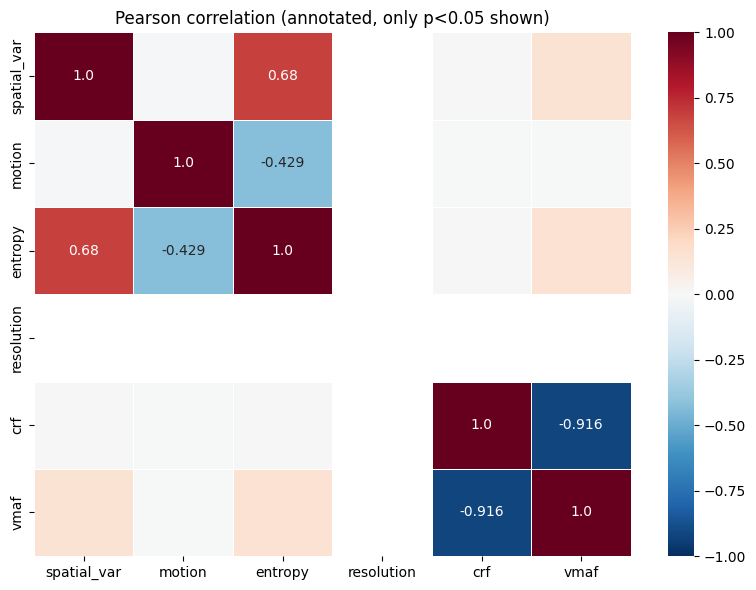

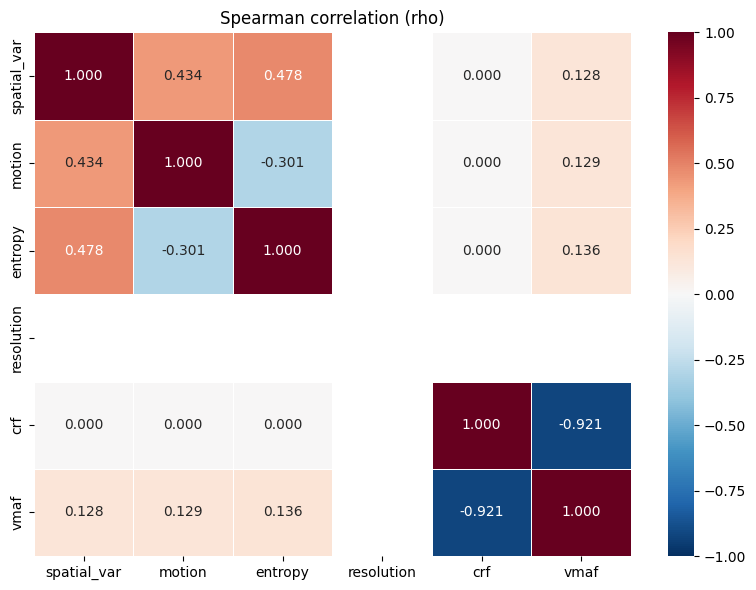


Top features correlated with VMAF (by absolute Pearson r):
crf            0.916017
entropy        0.150071
spatial_var    0.148006
motion         0.000679
resolution          NaN
Name: vmaf, dtype: float64

Top features correlated with CRF (by absolute Pearson r):
vmaf           9.160169e-01
motion         3.971899e-16
entropy        1.843126e-16
spatial_var    9.451058e-17
resolution              NaN
Name: crf, dtype: float64
Saved: metrics/correlation_summary.csv


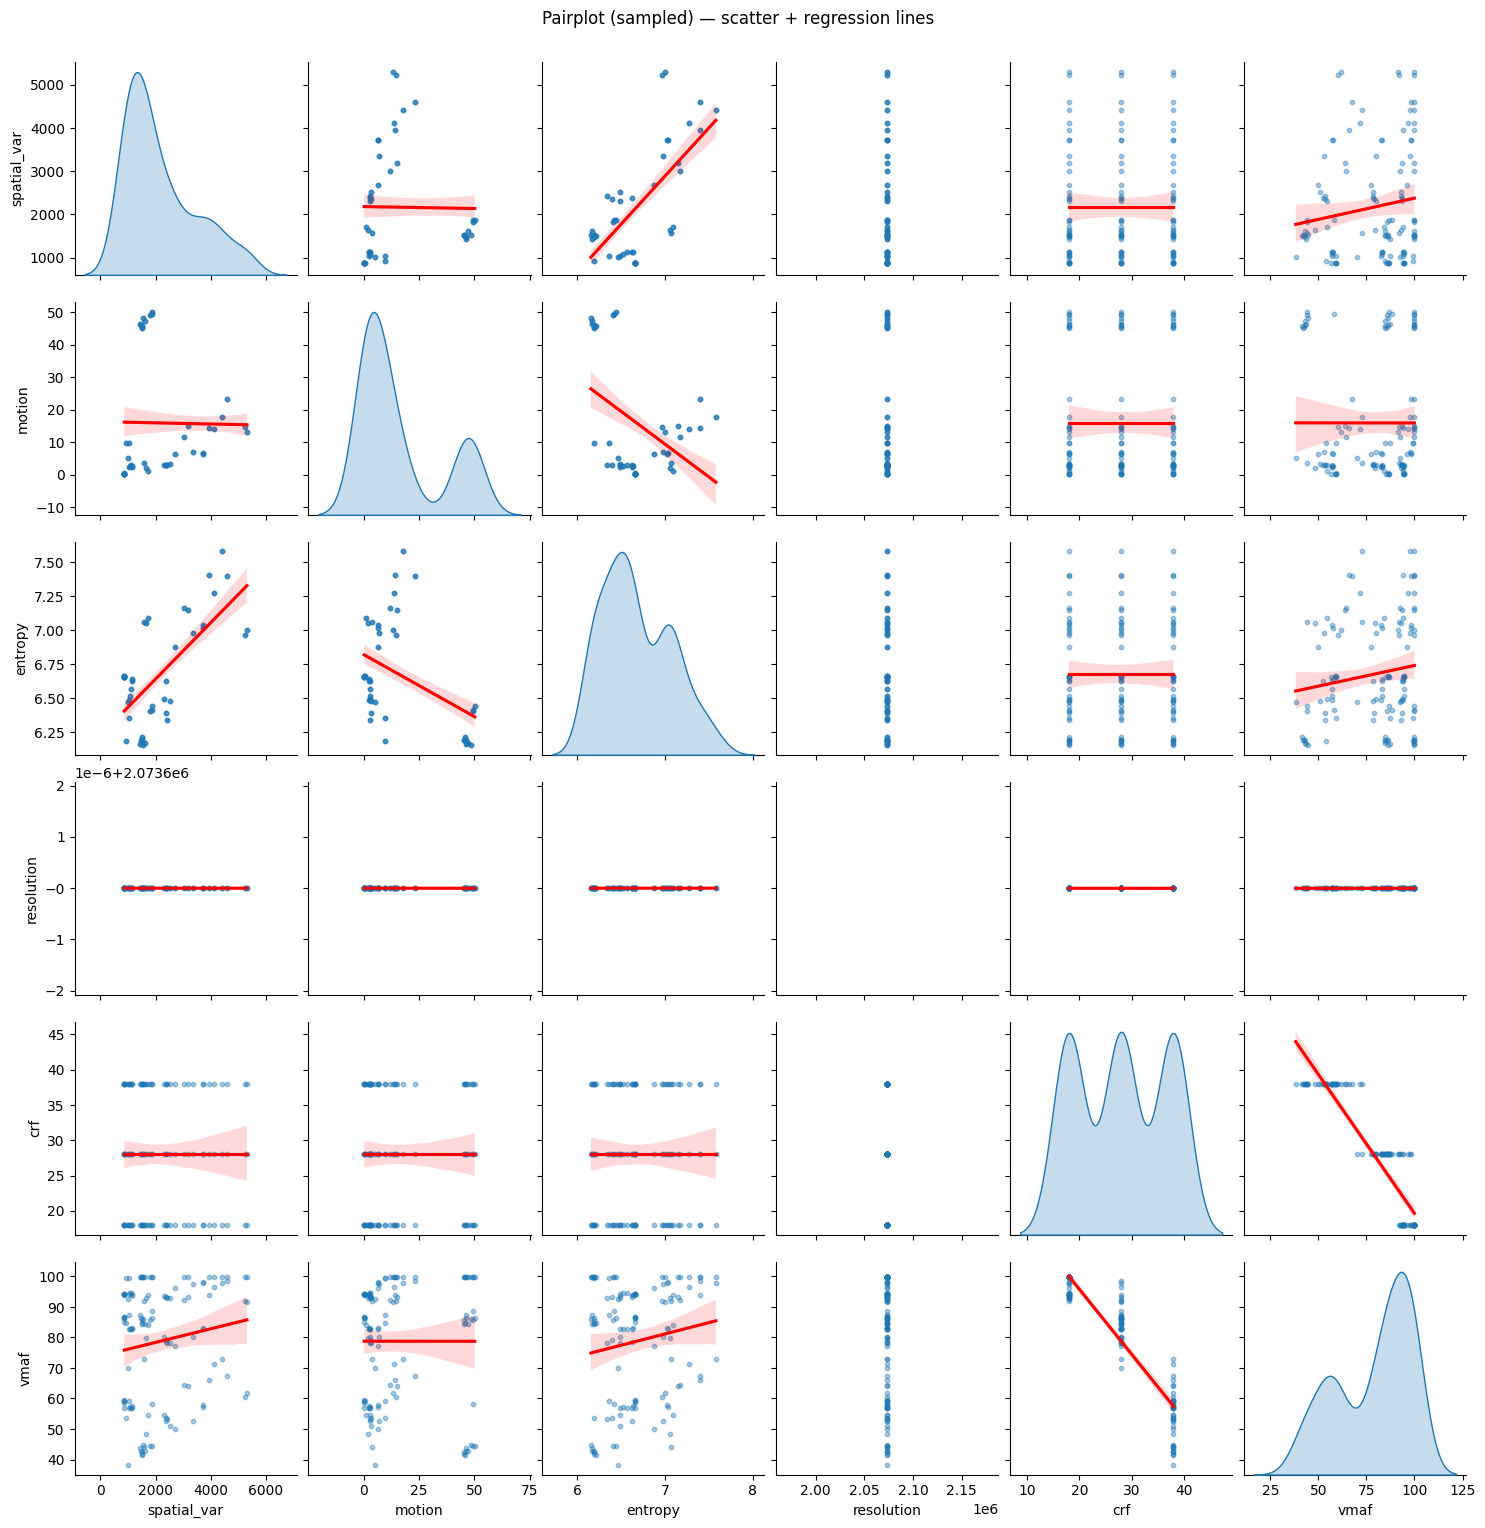

Saved: metrics/pairwise_pearson_long.csv

Done. Check the `metrics/` CSV files and `figures/` images for results.


C:\Users\acer\AppData\Local\Temp\ipykernel_14728\1242963414.py:117: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(df_num_clean[a], df_num_clean[b])


In [72]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create output dirs
os.makedirs('metrics', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# 1) Load df_merged if not already in memory
try:
    df_merged
except NameError:
    if os.path.exists('final_dataset.csv'):
        df_merged = pd.read_csv('final_dataset.csv')
        print('Loaded final_dataset.csv into df_merged')
    else:
        raise FileNotFoundError('df_merged is not defined and final_dataset.csv not found')

# 2) Select numeric columns of interest
cols = ['spatial_var', 'motion', 'entropy', 'resolution', 'crf', 'vmaf']
missing = [c for c in cols if c not in df_merged.columns]
if missing:
    raise KeyError(f'Missing columns in df_merged: {missing}')

df_num = df_merged[cols].copy()

# Optional: drop rows with NaNs in the selected columns for correlation calc
df_num_clean = df_num.dropna().reset_index(drop=True)
n_rows = len(df_num_clean)
print(f'Using {n_rows} rows for correlation (dropped NaNs)')

# 3) Pearson and Spearman correlation matrices
pearson_corr = df_num_clean.corr(method='pearson')
spearman_corr = df_num_clean.corr(method='spearman')

pearson_corr.to_csv('metrics/pearson_corr.csv')
spearman_corr.to_csv('metrics/spearman_corr.csv')
print('Saved: metrics/pearson_corr.csv and metrics/spearman_corr.csv')

# 4) Compute pairwise Pearson p-values matrix
def pearson_pval_matrix(df):
    cols = df.columns
    pvals = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)
    for i, a in enumerate(cols):
        for j, b in enumerate(cols):
            if i >= j:
                # compute only once; diagonal remains 0
                if i == j:
                    pvals.loc[a, b] = 0.0
                else:
                    r, p = stats.pearsonr(df[a], df[b])
                    pvals.loc[a, b] = p
                    pvals.loc[b, a] = p
    return pvals

pval_matrix = pearson_pval_matrix(df_num_clean)
pval_matrix.to_csv('metrics/pearson_pvalues.csv')
print('Saved: metrics/pearson_pvalues.csv')

# 5) Pretty heatmap for Pearson correlations (annotated) with mask for significance
plt.figure(figsize=(8,6))
mask = np.zeros_like(pearson_corr, dtype=bool)
mask[np.triu_indices_from(mask, 1)] = True  # mask upper triangle to reduce clutter

# annotate only correlations with p < 0.05; otherwise show as blank or small value
annot = pearson_corr.round(3).astype(str)
annot[pval_matrix >= 0.05] = ''

sns.heatmap(pearson_corr, annot=annot, fmt='', cmap='RdBu_r', center=0, vmin=-1, vmax=1, linewidths=.5)
plt.title('Pearson correlation (annotated, only p<0.05 shown)')
plt.tight_layout()
plt.savefig('figures/pearson_corr_heatmap.png', dpi=200)
plt.show()

# 6) Heatmap for Spearman correlations (full annotation)
plt.figure(figsize=(8,6))
sns.heatmap(spearman_corr.round(3), annot=True, fmt='.3f', cmap='RdBu_r', center=0, vmin=-1, vmax=1, linewidths=.5)
plt.title('Spearman correlation (rho)')
plt.tight_layout()
plt.savefig('figures/spearman_corr_heatmap.png', dpi=200)
plt.show()

# 7) Top correlations with VMAF and CRF (sorted lists)
vmaf_corr = pearson_corr['vmaf'].drop('vmaf').abs().sort_values(ascending=False)
crf_corr = pearson_corr['crf'].drop('crf').abs().sort_values(ascending=False)
print('\nTop features correlated with VMAF (by absolute Pearson r):')
print(vmaf_corr)
print('\nTop features correlated with CRF (by absolute Pearson r):')
print(crf_corr)

# Save summary
summary = pd.DataFrame({'pearson_with_vmaf': pearson_corr['vmaf'], 'pearson_with_crf': pearson_corr['crf']})
summary.to_csv('metrics/correlation_summary.csv')
print('Saved: metrics/correlation_summary.csv')

# 8) Pairplot (regression) - sample if large to keep it responsive
sample_size = 500
if n_rows > sample_size:
    sample_df = df_num_clean.sample(sample_size, random_state=42)
    print(f'Pairplot using a random sample of {sample_size} rows')
else:
    sample_df = df_num_clean

sns.pairplot(sample_df, vars=cols, kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'alpha':0.4, 's':10}})
plt.suptitle('Pairplot (sampled) — scatter + regression lines', y=1.02)
plt.savefig('figures/pairplot_sample.png', dpi=160, bbox_inches='tight')
plt.show()

# 9) Quick statistical table: Pearson r and p-values for each pair (long form)
pairs = []
for i, a in enumerate(df_num_clean.columns):
    for j, b in enumerate(df_num_clean.columns):
        if i < j:
            r, p = stats.pearsonr(df_num_clean[a], df_num_clean[b])
            pairs.append({'var1': a, 'var2': b, 'pearson_r': r, 'p_value': p})

pairs_df = pd.DataFrame(pairs).sort_values('pearson_r', key=lambda s: s.abs(), ascending=False).reset_index(drop=True)
pairs_df.to_csv('metrics/pairwise_pearson_long.csv', index=False)
print('Saved: metrics/pairwise_pearson_long.csv')

print('\nDone. Check the `metrics/` CSV files and `figures/` images for results.')


In [75]:
import subprocess

input_yuv = "segments/FlowerKids_3840x2160_50fps_8bit.yuv"
output_mp4 = "encoded_FlowerKids_crf30.mp4"
width, height, fps = 3840, 2160, 50

cmd = [
    "ffmpeg", "-y",
    "-f", "rawvideo", "-pix_fmt", "yuv420p",
    "-s:v", f"{width}x{height}", "-r", str(fps),
    "-i", input_yuv,
    "-c:v", "libx264", "-crf", "30",
    "-preset", "medium",
    output_mp4
]

subprocess.run(cmd, check=True)
print("✅ Encoding completed → encoded_FlowerKids_crf30.mp4")


✅ Encoding completed → encoded_FlowerKids_crf30.mp4
